#Visualization

* Nama: Sandrine Nataprawira 
* NIM: 2301953510
* Kelas: BF01

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [ ]:
spark.read.csv("MsCustomer.csv", header=True).createOrReplaceTempView("customer")
spark.read.csv("MsDriver.csv", header=True).createOrReplaceTempView("driver")
spark.read.csv("MsFood.csv", header=True).createOrReplaceTempView("food")
spark.read.csv("MsRestaurant.csv", header=True).createOrReplaceTempView("resto")
spark.read.csv("TransactionDetail.csv", header=True).createOrReplaceTempView("transaction_detail")
spark.read.csv("TransactionHeader.csv", header=True).createOrReplaceTempView("transaction_header")

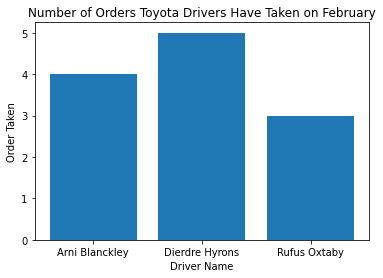

In [ ]:
# a.	Show how many orders JrebFood drivers who drived using 
# Toyota have taken in February using barplot.

data = spark.sql("""
  select 
  d.drivername as name, 
  count(th.transactionid) as order
  from driver d
    join transaction_header th on th.driverid = d.driverid
  where d.drivervehicle = "Toyota" and month(transactiondate) = 2
  group by d.driverid, d.drivername
  order by name
""").toPandas()

plt.bar(data["name"], data["order"])
plt.xlabel("Driver Name")
plt.ylabel("Order Taken")
plt.title("Number of Orders Toyota Drivers Have Taken on February")
plt.show()

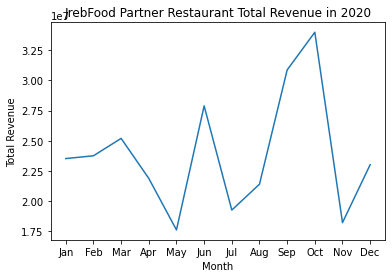

In [ ]:
# b.	Show JrebFood partner restaurant revenue 
# for every month in 2020 using line plot.

data = spark.sql("""
  Select 
    case 
      when month(th.transactiondate) = 1 then 'Jan'
      when month(th.transactiondate) = 2 then 'Feb'
      when month(th.transactiondate) = 3 then 'Mar'
      when month(th.transactiondate) = 4 then 'Apr'
      when month(th.transactiondate) = 5 then 'May'
      when month(th.transactiondate) = 6 then 'Jun'
      when month(th.transactiondate) = 7 then 'Jul'
      when month(th.transactiondate) = 8 then 'Aug'
      when month(th.transactiondate) = 9 then 'Sep'
      when month(th.transactiondate) = 10 then 'Oct'
      when month(th.transactiondate) = 11 then 'Nov'
      when month(th.transactiondate) = 12 then 'Dec'
    end
       as month,
    sum(f.foodprice*td.quantity) as revenue,
    r.ispartner
    
  From resto r
  JOIN transaction_header th
  ON th.restaurantid = r.restaurantid
  JOIN transaction_detail td
  on th.transactionid = td.transactionid
  JOIN food f
  ON td.foodid = f.foodid
  WHERE YEAR(th.TransactionDate) = '2020' and r.ispartner = 'TRUE'
  GROUP BY r.ispartner, month(th.transactiondate)
  ORDER BY month(transactiondate)
 """).toPandas()

plt.plot(data["month"], data["revenue"])

plt.xticks(range(0,12))
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("JrebFood Partner Restaurant Total Revenue in 2020")
plt.show()

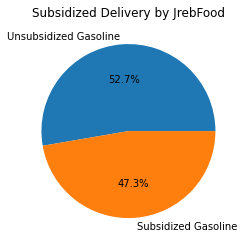

In [ ]:
data = spark.sql("""
select 
label, count(*) as total 
from(
  select distance,
    case 
    when distance > (select avg(distance) from transaction_header where month(transactiondate) =1) then 'Subsidized Gasoline'
    when distance <= (select avg(distance) from transaction_header where month(transactiondate) =1) then 'Unsubsidized Gasoline'
    end as label
    from transaction_header th
)
group by label
""").toPandas()

plt.pie(data["total"], labels=data["label"], autopct="%.1f%%")
plt.title("Subsidized Delivery by JrebFood")
plt.show()
